In [51]:
import numpy as np
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
import sys
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

def plotCurve(train_mean, train_std,test_mean,test_std,sizes):
    plt.plot(sizes, train_mean, 
            color='blue', marker='o', 
            markersize=5, 
            label='training accuracy')
    plt.fill_between(sizes, 
                  train_mean + train_std,
                   train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(sizes, test_mean, 
              color='green', linestyle='--', 
              marker='s', markersize=5, 
             label='validation accuracy')
    plt.fill_between(sizes, 
                      test_mean + test_std,
                     test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('x_range')
    plt.ylabel('Accuracy')
    plt.show()
def likehoodScore(proba,y):
    return np.sum(proba * y)/proba.shape[0]

def firstNScore(n, pred, y):
    backup = np.array(pred, copy =True)
    for r in range(pred.shape[0]):
        row = backup[r]
        s = np.sort(row)
        for c in range(pred.shape[1]):
            temp = backup[r][c]
            backup[r][c] = False
            for j in range(1,n+1):
                if temp == s[-j]:
                    backup[r][c] = True
                    break
    res = np.sum(np.logical_and(backup,y))/pred.shape[0]
    return res               

def oneHotDecode(self, X_sample):
    result=None
    fiPos = 0
    colIndex = 0
    while colIndex < X_sample.shape[1]:
        if fiPos < len(self.ohe.n_values_) and colIndex == self.ohe.feature_indices_[fiPos]:                
            start = self.ohe.feature_indices_[fiPos]
            end_ = start+ self.ohe.n_values_[fiPos]
            #print("start{} end{}".format(start,end_))
            classes = np.argmax(X_sample[:,start:end_],axis=1).reshape(X_sample.shape[0],1)
            if result is None:
                result = classes
            else:
                result=np.hstack([result,classes])
            colIndex = end_
            fiPos = fiPos +1
        else:
            if result is None:
                result = X_sample[:,colIndex:colIndex+1]
            else:
                result=np.hstack([result, X_sample[:,colIndex:colIndex+1]])
            colIndex = colIndex +1
        
    return result 
def convertToDate(dayStamps):
    res = [] 
    for v in dayStamps:
        res.append(datetime.datetime.fromtimestamp(v*24*60*60))
    return res

#TODO confusion matrix ,e.g. 100 - 90 % precision
def _precisionClassify(df,proba, wins, c =0 ):
    for indx, v in enumerate(proba):
        row = 0
        col = 0
        if wins[indx] == c:
            col = 0
        else:
            col =1
        if v <0.2:
            row =6 
        elif v < 0.3 and  v >=0.2:
            row =5 
        elif v < 0.4 and v >= 0.3:
            row = 4 
        elif v < 0.5 and v >= 0.4:
            row = 3 
        elif v < 0.6 and v >= 0.5:
            row = 2 
        elif v < 0.8 and v >= 0.6:
            row = 1
        df.iloc[row,col] = df.iloc[row,col]+1 
    df[df.columns[2]] = df[df.columns[0]] /(df[df.columns[1]] + df[df.columns[0]])
    return df
    

def precisionMatrix(proba, y):
    rowHeader = ['>80','60-80','50-60','40-50','30-40','20-30','<20']
    df = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['h_Correct', 'h_Wrong','h_Precent'])
    hproba = proba[:,0]
    wins = np.argmax(y,axis=1)
    df = _precisionClassify(df,hproba,wins)
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['d_Correct', 'd_Wrong','d_Precent'])
    dproba = proba[:,1]
    df = df.join(_precisionClassify(temp,dproba,wins,c=1))
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['a_Correct', 'a_Wrong','a_Precent'])
    aproba = proba[:,2]
    df = df.join(_precisionClassify(temp,aproba,wins,c=2))
    return df
       
from datetime import date, timedelta
from sklearn.metrics import precision_score


def futureTest(mlp, X,y,numOfWeek = 10,verbose=False):
    decoded = oneHotDecode(c, X)
    dates = convertToDate(X[:,c.dateColumn])
    dates = [d - timedelta(days=2) for d in dates]    
    weeks  = [ v.isocalendar()[1] for v in dates]
    thisWeek = weeks[-1]
    start = -1
    last = X.shape[0]
    index = -1
    w = 0
    sum_proba =None 
    sum_y =None
    sum_train_proba=None
    sum_train_y=None
    while w < numOfWeek:
        if thisWeek != weeks[index]:
            start = X.shape[0] +index+1
            X_train = X[0:start, :]
            X_test = X[start:last,:]
            y_train = y[0:start,:]
            y_test = y[start:last,:]
            mlp.fit(X_train,y_train)
            decoded = oneHotDecode(c,X_test)
            home = np.array([c.inverseTeamMapping(decoded[:,0])]).reshape(X_test.shape[0],1)
            away = np.array([c.inverseTeamMapping(decoded[:,1])]).reshape(X_test.shape[0],1)
            stack = np.hstack([home,away])
            proba = mlp.predict_proba(X_test)
            train_proba =mlp.predict_proba(X_train)
            errorIndx = np.argmax(proba,axis=1) != np.argmax(y_test,axis=1)
            if sum_proba is None:
                sum_proba = proba
                sum_y = y_test
                sum_train_proba = train_proba
                sum_train_y = y_train
            else:
                sum_proba = np.vstack([sum_proba,proba])
                sum_y = np.vstack([sum_y,y_test])
                sum_train_proba = np.vstack([sum_train_proba, train_proba])
                sum_train_y= np.vstack([sum_train_y, y_train])
            if verbose == True:
                print("week{}".format(w))
                print("numOftest {} , score {}".format(X_test.shape[0],mlp.score(X_test,y_test)))
                print(np.hstack([stack[errorIndx],proba[errorIndx],y_test[errorIndx]]))
                print("first2 : {}",firstNScore(2,proba,y_test))
            last = start
            thisWeek = weeks[index]
            w = w+1
        index = index -1
        
    print("summary")
    print("score:")
    score = firstNScore(1,sum_proba,sum_y)
    print(score)
    print("2like")
    like2 = firstNScore(2,sum_proba,sum_y)
    print(precisionMatrix(sum_proba,sum_y))
    y_true= np.argmax(sum_y,axis=1)
    y_pred = np.argmax(sum_proba,axis=1)
    print("sum precision:{}".format(precision_score(y_true,y_pred,average=None)))
    return firstNScore(1,sum_train_proba,sum_train_y), score, like2


In [166]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
class FootballDataHelper:
    def __init__ (self, recentNum=5):
        self.win_mapping = {'H':0, 'D':1,'A':2}
        self.recentNum = recentNum
        self.df = None
        self.teamsData={}
        self.session = 0
        #self.hiddensCount = 2
       
        
    def readFootBallData(self,filename): 
        df = pd.read_csv(filename)
        #df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        #df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
        df['session'] = pd.Series(np.ones(shape=(df.shape[0],))*self.session, index=df.index)
        self.session = self.session +1
        #df= df.drop('Referee', 1)
        #self.team = df['HomeTeam'].drop_duplicates()
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
            
        self.df = self.df.reset_index(drop=True)
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
        referees = self.df['Referee'].drop_duplicates()
        refereesMap = {}
        for index , v in enumerate(referees):
            refereesMap[v] = index+1

        self.refereesMap = refereesMap
 
    def getTeam(self,dataFrame, teamName):       
        return dataFrame[(dataFrame["HomeTeam"] == teamName) | (dataFrame["AwayTeam"] == teamName)]
 
        
    def previousRecords(self,team, date , recentNum):
        prev = team[( team["Date"] < date)]
        
        if prev.shape[0] < recentNum :
            #print("less than min Num")
            return None
        else:
            return prev.iloc[-recentNum:]
    def readPredict (self, filename):
        df = pd.read_csv(filename)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

        return df
    
    
  
    def inverseTeamMapping (self, col):
        inverseMap ={}
        for name in self.teamsMap.keys():        
            inverseMap[self.teamsMap[name]] = name
        res =[]
        for idex, v in enumerate(col):
            res.append(inverseMap[v])
        return res

    def _getH6RecentMatches(self,x, X,teamName,recentNum):
        team = self.getTeam(X,teamName)
        prev = self.previousRecords(team,x['Date'],recentNum)
        if prev is None:
               return None
        prevHt=  prev['HomeTeam'].values
        prevAt=  prev['AwayTeam'].values   
        prevIsHome = []
        prevOther = []
        for i in range(recentNum):
            if prevHt[i] == teamName:
                prevIsHome.append(1)
                prevOther.append(prevAt[i])
            else:
                prevIsHome.append(0)
                prevOther.append(prevHt[i])
        wins = prev['FTR'].values       
        temp = np.array([prevIsHome,prev['FTHG'].values,prev['FTAG'].values,prev['HY'].values,prev['AY'].values,
                         prev['HR'].values,prev['AR'].values,prevOther,wins]).T

        return temp

    def readTeamMatch(self, teamName):
        df = pd.read_csv('teams/'+teamName+'.csv')
        df['1'] = pd.to_datetime(df['1'],yearfirst=True)
        #df['1']= (pd.to_numeric(df['1'])/1e9/24/60/60)
        self.teamsData[teamName]=df.sort(['1'],ascending=[False])
        self.teamsById[self.teamsMap[teamName]]=self.teamsData[teamName]
    
    def commonMapping(self, X):
        X['HomeTeam'] = X['HomeTeam'].map(self.teamsMap)
        X['AwayTeam'] = X['AwayTeam'].map(self.teamsMap)
        X['Referee']=X['Referee'].map(self.refereesMap).fillna(0)
        X['HTR'] = X['HTR'].map(self.win_mapping)
        X['FTR'] = X['FTR'].map(self.win_mapping)
        return X
    def initData(self, X, target,encode):
        X  = X.sort_values(by="Date")
        isInput = False
        if target is None:
            target =X      
        else:
            if self.ohe is None:
                raise Exception("Not yet get train data")
            isInput = True
            if encode == True:
                target = self.commonMapping(target)
        y=None
        if encode == True:    
            X =self.commonMapping(X)
            y = []
            for v in target['FTR']:
                y.append(range(3)==v)
        else:
            y = target['FTR'].values
        target_date = (pd.to_numeric(target['Date'])/1e9/24/60/60).values
        return isInput, X,y, target, target_date
   
    def aggregate(self,recents,nonExpand,isInput,encode):
        res =None
        if encode == True:
            if isInput==False:
                self.ohe = OneHotEncoder(categorical_features='all')
                self.ohe.fit(recents)
            res = self.ohe.transform(recents).toarray()
        else:
            res = np.array(recents)
        self.dateColumn = res.shape[1]
        res = np.hstack([res,nonExpand])
        return res
    def _extractFromPrevious(self, prev,teamName):
        homes =  prev['HomeTeam'].values
        ftr = prev['FTR'].values
        homeGoals = prev['FTHG'].values
        awayGoals = prev['FTAG'].values
        homeYellow = prev['HY'].values
        awayYellow = prev['AY'].values
        homeRed = prev['HR'].values
        awayRed =prev['AR'].values
        scored = 0
        conceded = 0
        wins = 0
        draw =0
        lose = 0
        yellowCards = 0
        redCards = 0
        for i in range(ftr.shape[0]):
            if homes[i] == teamName:
                if ftr[i] == 'H' or ftr[i] == 0:
                    wins = wins+1
                elif ftr[i] == 'A' or ftr[i] == 2:
                    lose = lose+1
                else:
                    draw = draw +1
                scored = scored + homeGoals[i]
                conceded = conceded + awayGoals[i]
                yellowCards = yellowCards + homeYellow[i]
                redCards = redCards + homeRed[i]
                
            else:
                if ftr[i] == 'A' or ftr[i] == 2:
                    wins = wins+1
                elif ftr[i] == 'H' or ftr[i] == 0:
                    lose = lose+1
                else:
                    draw = draw +1
                scored = scored + awayGoals[i]
                conceded = conceded + homeGoals[i]
                yellowCards = yellowCards + awayYellow[i]
                redCards = redCards + awayRed[i]
                              
        temp = np.array([wins,draw,lose,scored,conceded])
        return temp
    def _getH7RecentMatches(self,x, X,teamName,recentNum,isHome):
        team = self.getTeam(X,teamName)
        homeOrAway = None
        if isHome == True:
            homeOrAway = X[X['HomeTeam']==teamName]
        else:
            homeOrAway = X[X['AwayTeam']==teamName]
        prev = self.previousRecords(team,x['Date'],recentNum)
        prevHomeOrAway = self.previousRecords(homeOrAway,x['Date'],recentNum)
        if prev is None or prevHomeOrAway is None:
            return None
        res1= self._extractFromPrevious(prev,teamName)
        #res2= self._extractFromPrevious(prevHomeOrAway,teamName)
        
        return res1
    def getH7(self, recentNum, target=None,encode = True):
        #Simple recent win,draw, lose 
        isInput, X, y,target, target_date = self.initData(self.df,target,encode)
        resy=[]
        resx=[]
        print("start format")
        recents = []
        nonExpand =[]
        for i in range(target.shape[0]):
            
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            x = target.iloc[i]
            homeName = x['HomeTeam']
            awayName = x['AwayTeam']
            homeRecent = self._getH7RecentMatches(x,X,homeName, recentNum,True)
            awayRecent =self._getH7RecentMatches(x,X,awayName, recentNum,False)
            if homeRecent is None or awayRecent is None:
                   continue 
            #print(homeName)
           # print(homeRecent)
          #  print(awayName)
         #   print(awayRecent)
            #return
            referee = x['Referee']
            homeData=None
            if encode == True:
                homeData = self.teamsById[homeName]
            else:
                homeData = self.teamsData[homeName]
            prevDayDiff = (x['Date']-homeData[homeData['1']<x['Date']].values[0][1]).days
            if recentNum == 0:
                recents.append(np.hstack([homeName,awayName,referee]))
                nonExpand.append(target_date[i])
            else:
                recents.append(np.hstack([homeName,awayName,referee]))
                nonExpand.append(np.hstack([target_date[i],prevDayDiff,homeRecent,awayRecent]))

            resy.append(y[i])
        res = self.aggregate(recents,nonExpand,isInput,encode)
        print("finish")
        sys.stdout.flush()
        return res, np.array(resy)
    def _getRank(self,x, X,teamName,recentNum):
        team = self.getTeam(X,teamName)
        prev = team[team['Date'] < x['Date']].values      
        for i in range(recentNum):
            pass
    def initRanking(self, n = 20):
        defaultPt = 1
        df = self.df.sort(columns=["Date"],ascending=[False])
        df["HPoints"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["APoints"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HAccP"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AAccP"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        hpoints= df["HPoints"].values
        apoints=df["APoints"].values
        ftr = df["FTR"].values
        for i in range(df.shape[0]):
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            if ftr[i] == 'H':
                hpoints[i] = 3
                apoints[i] = 0
            elif ftr[i] == 'D':
                hpoints[i] = 1
                apoints[i] = 1
            else :
                hpoints[i] = 0
                apoints[i] = 3
        df["HPoints"]=hpoints
        df["APoints"]=apoints
        for teamName in self.teamsMap.keys():
            print(teamName)
            team  = df[(df['HomeTeam']==teamName) | (df['AwayTeam'] == teamName)] 
            hometeam = team['HomeTeam'].values
            hpoints = team['HPoints'].values
            apoints = team['APoints'].values
            psum = 0
            haccp = team['HAccP'].values
            aaccp = team['AAccP'].values
        
            for  i in range(0,n):
                if i < hpoints.shape[0]:
                    psum = psum + (hpoints[i] if hometeam[i] == teamName else apoints[i] ) 
                else:
                    psum = psum + defaultPt        
                    
        
            for j in range(team.shape[0]):

                if j+n < hpoints.shape[0]:                     
                    psum = psum + (hpoints[j+n] if hometeam[j+n]==teamName else apoints[j+n])
                else:
                    psum = psum + defaultPt 
                
                psum = psum - (hpoints[j] if hometeam[j]==teamName else apoints[j])
                    
                if hometeam[j] == teamName:
                    haccp[j]=psum
                else:
                    aaccp[j]=psum
            team['HAccp']=haccp
            team['AAccP']=aaccp
            #print(team[['HomeTeam','AwayTeam','HAccP','AAccP']])
            df.update(team)
            
            #print(df[['HomeTeam','AwayTeam','HAccP','AAccP']])
                    
        return df
    def initTeamData(self):
        self.teamsData={}
        self.teamsById={}
        for name in self.teamsMap.keys():
            self.readTeamMatch(name)
            

In [167]:
c = FootballDataHelper()
#c.readFootBallData("E0_1112.csv")
c.readFootBallData("E0_1213.csv")
c.readFootBallData("E0_1314.csv")
c.readFootBallData("E0_1415.csv")
c.readFootBallData("E0 (1).csv")
c.initTeamData()

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:98: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [168]:

df = c.initRanking()
df.to_csv('temp.csv')
print(df)

 progress 1432

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:250: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Cardiff
Everton
Watford
Swansea
West Ham
Crystal Palace
Stoke
Fulham
Man United
Bournemouth
Norwich
Newcastle
Reading
Arsenal
QPR
Liverpool
Sunderland
Man City
Wigan
Chelsea
Southampton
Hull
Leicester
West Brom
Burnley
Tottenham
Aston Villa
      AC  AF  AR  AS  AST  AY        AwayTeam  B365A  B365D  B365H  ...    \
1432   4   9   0  13    2   0       Newcastle   6.25   4.33   1.57  ...     
1431   8   6   0  19    8   0       Tottenham   1.50   4.50   7.50  ...     
1430   4  12   1  11    4   2     Southampton   2.90   3.20   2.70  ...     
1429   8  10   0  15    3   1        Man City   1.60   4.20   6.00  ...     
1428   3  11   0  12    4   0         Swansea   4.33   3.50   1.95  ...     
1427   5   7   1   7    1   0      Man United   2.00   3.40   4.33  ...     
1426   6  16   1  19    5   2       Liverpool   2.10   3.50   3.80  ...     
1421   4   8   0  16    5   3     Bournemouth   2.88   3.40   2.63  ...     
1418   4  10   0  16    5   2           Stoke   7.50   4.50   1.50

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [76]:
X,y = c.getH7(5)


start format
 progress 1432finish


In [77]:
%matplotlib qt
def plotErrorDate(X_test, X_err, dateCol = 10):
    X_test_date =np.sort(X_test[:,c.dateColumn])
    X_date=[]
    y_date=[]
    for v in X_test_date:
        date = datetime.datetime.fromtimestamp(v*24*60*60)
        if len(X_date) ==0  or X_date[-1] != date:
            X_date.append(date)
            y_date.append(1)
        else:
            y_date[-1] = y_date[-1] +1
    plt.plot_date(X_date,y_date,xdate=True)
    X_err_d = np.sort(X_err[:,c.dateColumn])
    X_err_date=[]
    y_err_date = []
    for v in X_err_d:
        date = datetime.datetime.fromtimestamp(v*24*60*60)
        if len(X_err_date) ==0  or X_err_date[-1] != date:
            X_err_date.append(date)
            y_err_date.append(1)
        else:
            y_err_date[-1] = y_err_date[-1] +1
    plt.plot_date(X_err_date,y_err_date,xdate=True,color='red')
    plt.show()



In [78]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
g_hiddenNodes = int(40)
g_alpha = 35 
clf = SoftMaxMLPClassifier(hidden_layer_sizes=[g_hiddenNodes], activation='logistic', algorithm='l-bfgs', alpha=g_alpha, 
              learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=1000,early_stopping = True,verbose = 3)
mlp = Pipeline([ ('scl', StandardScaler()),('clf', clf)])

In [79]:
print ("start learning")
sys.stdout.flush()
train_sizes, train_scores, test_scores = learning_curve(estimator=mlp, 
                       X=X, 
                      y=y, 
                      train_sizes=np.linspace(0.1, 1.0, 4), 
                      cv=4,
                     n_jobs=1,verbose=3)
print("finishing")   
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


print(test_mean)

start learning
[learning_curve] Training set sizes: [ 94 376 659 942]
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.439490 -   0.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.442675 -   0.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.528662 -   0.8s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.541401 -   0.6s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.468153 -   0.1s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.464968 -   0.6s
[CV] no parameters to be set .........................................
[CV] ..

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    7.4s finished


In [80]:
learningRes = np.vstack([train_sizes,train_mean,train_std,test_mean,test_std]).T


In [81]:
learningDf = pd.DataFrame(learningRes,columns=['size','train_mean','train_std','test_mean','test_std'])
print(learningDf)

   size  train_mean  train_std  test_mean  test_std
0    94    0.460106   0.004607   0.443471  0.018347
1   376    0.460771   0.015999   0.445064  0.016297
2   659    0.568665   0.010424   0.519108  0.032243
3   942    0.565287   0.014033   0.524682  0.035347


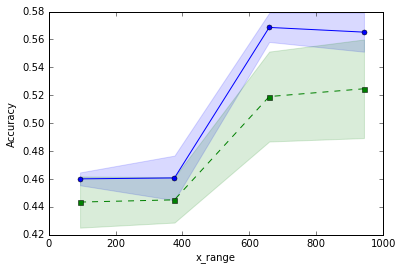

In [82]:
%matplotlib inline
plotCurve(train_mean,train_std,test_mean,test_std,train_sizes)


In [84]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate(mlp, X,y, fold = 10):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=fold,
                            random_state=1)

    scores = []
    train_scores=[]
    firstNScores = []
    for k, (train, test) in enumerate(kfold):

        mlp.fit(X[train], y[train])
        score = mlp.score(X[test], y[test])
        firstNScores.append(firstNScore(2, mlp.predict_proba(X[test]), y[test]))
        train_scores.append(mlp.score(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
        
        
    return train_scores,scores, firstNScores



Fold: 1, Class dist.: [487 267 343], Acc: 0.390
Fold: 2, Class dist.: [487 267 344], Acc: 0.399
Fold: 3, Class dist.: [487 268 344], Acc: 0.465
Fold: 4, Class dist.: [487 268 344], Acc: 0.433
Fold: 5, Class dist.: [487 268 344], Acc: 0.433
Fold: 6, Class dist.: [488 268 344], Acc: 0.397
Fold: 7, Class dist.: [488 268 344], Acc: 0.417
Fold: 8, Class dist.: [488 268 344], Acc: 0.353
lamda: 0, train: 1.0, test: 0.41081851773536227
Fold: 1, Class dist.: [487 267 343], Acc: 0.553
Fold: 2, Class dist.: [487 267 344], Acc: 0.532
Fold: 3, Class dist.: [487 268 344], Acc: 0.567
Fold: 4, Class dist.: [487 268 344], Acc: 0.516
Fold: 5, Class dist.: [487 268 344], Acc: 0.484
Fold: 6, Class dist.: [488 268 344], Acc: 0.513
Fold: 7, Class dist.: [488 268 344], Acc: 0.481
Fold: 8, Class dist.: [488 268 344], Acc: 0.442
lamda: 10, train: 0.6433151155532408, test: 0.5109851382382831
Fold: 1, Class dist.: [487 267 343], Acc: 0.560
Fold: 2, Class dist.: [487 267 344], Acc: 0.538
Fold: 3, Class dist.: [48

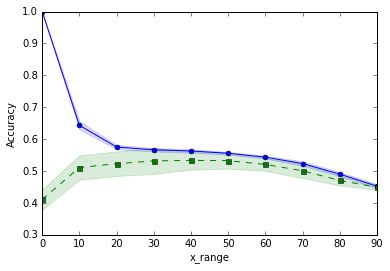

In [85]:

def lamda_test(mlp, X, y, lamdas):
    
    train_scores=[]
    test_scores=[]
    for lamda in lamdas:
        clf.set_params(alpha= lamda)
        train_s, test_s, firstNScores = crossValidate(mlp,X,y,fold=8)
      #  train_s, test_s, firstNScores =futureTest(mlp,X,y,numOfWeek=20) 
        train_scores.append(train_s)
        test_scores.append(test_s)
        print("lamda: {}, train: {}, test: {}".format(lamda, 
                    np.mean(train_s), np.mean(test_s)) )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plotCurve(train_mean,train_std,test_mean,test_std,lamdas)
    return np.array(train_scores),np.array(test_scores)

l_range = []
for i in range(0,10):
    l_range.append(10*i)
train_scores,test_scores = lamda_test(mlp,X,y,np.array(l_range))
#50

In [86]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
alphaRes = np.vstack([l_range,train_mean,train_std,test_mean,test_std]).T
alphaDf = pd.DataFrame(alphaRes,columns=['alpha','train_mean','train_std','test_mean','test_std'])
print(alphaDf)

   alpha  train_mean  train_std  test_mean  test_std
0      0    1.000000   0.000000   0.410819  0.031851
1     10    0.643315   0.012861   0.510985  0.038302
2     20    0.575294   0.006585   0.522959  0.038534
3     30    0.566537   0.005437   0.531747  0.040777
4     40    0.562896   0.005490   0.533385  0.028775
5     50    0.555732   0.004190   0.532589  0.025197
6     60    0.543561   0.004287   0.520671  0.019868
7     70    0.523426   0.007147   0.500735  0.023206
8     80    0.490331   0.006150   0.470540  0.016041
9     90    0.452341   0.006314   0.449027  0.008236


In [87]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
def testNodeSize(start ,end):
    node_range = range(start,end,10)
    train_means = []
    train_std = []
    test_means =[]
    test_std=[]
    for node in node_range:   
        print("start node:{}".format(node))
        clf = SoftMaxMLPClassifier(hidden_layer_sizes=[node], activation='logistic', algorithm='l-bfgs', alpha=g_alpha, 
                  learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
        mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])
        train_scores,test_scores,first2 = crossValidate(mlp,X,y,fold=8)
      #  train_scores,test_scores , first2= futureTest(mlp, X,y,numOfWeek = 10)
        train_means.append(np.mean(train_scores))
        train_std.append(np.std(train_scores))
        test_means.append(np.mean(test_scores))
        test_std.append(np.std(test_scores))
        print("Node {}: train_mean {}  v.s. test_mean {}".format(node,np.mean(train_scores),np.mean(test_scores)))
    plotCurve(np.array(train_means),np.array(train_std),np.array(test_means),np.array(test_std),np.array(node_range))
    return node_range, train_means,train_std,test_means,test_std

start node:10
Fold: 1, Class dist.: [487 267 343], Acc: 0.541
Fold: 2, Class dist.: [487 267 344], Acc: 0.538
Fold: 3, Class dist.: [487 268 344], Acc: 0.567
Fold: 4, Class dist.: [487 268 344], Acc: 0.554
Fold: 5, Class dist.: [487 268 344], Acc: 0.541
Fold: 6, Class dist.: [488 268 344], Acc: 0.558
Fold: 7, Class dist.: [488 268 344], Acc: 0.513
Fold: 8, Class dist.: [488 268 344], Acc: 0.462
Node 10: train_mean 0.5642609463010293  v.s. test_mean 0.5341658563632307
start node:20
Fold: 1, Class dist.: [487 267 343], Acc: 0.541
Fold: 2, Class dist.: [487 267 344], Acc: 0.538
Fold: 3, Class dist.: [487 268 344], Acc: 0.567
Fold: 4, Class dist.: [487 268 344], Acc: 0.554
Fold: 5, Class dist.: [487 268 344], Acc: 0.535
Fold: 6, Class dist.: [488 268 344], Acc: 0.558
Fold: 7, Class dist.: [488 268 344], Acc: 0.519
Fold: 8, Class dist.: [488 268 344], Acc: 0.468
Node 20: train_mean 0.5646023733336034  v.s. test_mean 0.5349722421218457
start node:30
Fold: 1, Class dist.: [487 267 343], Acc: 

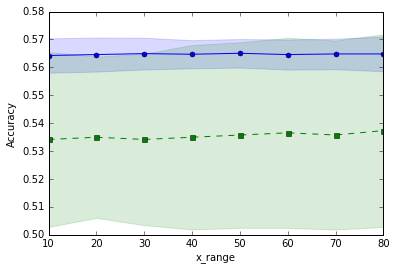

In [88]:
node_range, train_means,train_std,test_means,test_std=testNodeSize(10 ,X.shape[1] )

In [89]:
nodeRes = np.vstack([node_range,train_means,train_std,test_means,test_std]).T
nodeDf = pd.DataFrame(nodeRes,columns=['nodeNum','train_mean','train_std','test_mean','test_std'])
print(nodeDf)

   nodeNum  train_mean  train_std  test_mean  test_std
0       10    0.564261   0.006160   0.534166  0.031355
1       20    0.564602   0.006103   0.534972  0.028908
2       30    0.564944   0.005685   0.534176  0.030715
3       40    0.564717   0.005049   0.534972  0.033053
4       50    0.565058   0.005118   0.535758  0.033258
5       60    0.564602   0.005399   0.536555  0.034061
6       70    0.564830   0.005482   0.535768  0.033879
7       80    0.564830   0.006222   0.537351  0.034533


In [97]:
clf.set_params(alpha=g_alpha)
print(clf)
train_score, test_score, first2 = futureTest(mlp,X,y,numOfWeek = 30, verbose=True)      


SoftMaxMLPClassifier(activation='logistic', algorithm='l-bfgs', alpha=35,
           batch_size='auto', beta_1=0.9, beta_2=0.999,
           early_stopping=True, epsilon=1e-08, hidden_layer_sizes=[40],
           learning_rate='adaptive', learning_rate_init=0.01,
           max_iter=1000, momentum=0.9, nesterovs_momentum=True,
           power_t=0.5, random_state=None, shuffle=True, tol=0.0001,
           validation_fraction=0.1, verbose=3, warm_start=False)
week0
numOftest 5 , score 0.6
[['Norwich' 'Man City' '0.22723066636153086' '0.24422216250875942'
  '0.5285471711297097' 'False' 'True' 'False']
 ['Stoke' 'Southampton' '0.5782223802430215' '0.1826598891975066'
  '0.2391177305594718' 'False' 'False' 'True']]
first2 : {} 1.0
week1
numOftest 10 , score 0.4
[['Tottenham' 'Arsenal' '0.5658230242958316' '0.1942712522930565'
  '0.2399057234111119' 'False' 'True' 'False']
 ['Chelsea' 'Stoke' '0.8105946526265349' '0.11383694230400107'
  '0.07556840506946401' 'False' 'True' 'False']
 ['Evert

/home/y/scikit-learn/sklearn/metrics/classification.py:1098: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([ 0.56491228,  0.        ,  0.54862843])

In [98]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
from custom import SoftMaxMLPClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
def testRecentNum(start, end):
    recent_range = range(start,end)
    train_means = []
    train_std = []
    test_means =[]
    test_std=[]
    first2_mean=[]
    for recent in recent_range:
        print("start recent:{}".format(recent))
        X,y = c.getH7(recent)
        clf = SoftMaxMLPClassifier(hidden_layer_sizes=[g_alpha], activation='logistic', algorithm='l-bfgs', alpha=g_alpha, 
                  learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
        mlp = Pipeline([('scl', StandardScaler()),('clf', clf)])
        train_scores,test_scores, first2 = crossValidate(mlp,X,y,fold=10)
        #train_scores,test_scores, first2 = futureTest(mlp, X,y,numOfWeek = 15)
        train_means.append(np.mean(train_scores))
        train_std.append(np.std(train_scores))
        test_means.append(np.mean(test_scores))
        test_std.append(np.std(test_scores))
        first2_mean.append(np.mean(first2))
        print("recent {}: train_mean {}  v.s. test_mean {} , first2_mean {}".format(
                recent,np.mean(train_scores),np.mean(test_scores),np.mean(first2)))
    plotCurve(np.array(train_means),np.array(train_std),np.array(test_means),np.array(test_std),np.array(recent_range))
    return train_means,train_std,test_means,test_std,first2_mean



start recent:1
start format
 progress 1432finish
Fold: 1, Class dist.: [554 314 389], Acc: 0.532
Fold: 2, Class dist.: [554 314 389], Acc: 0.532
Fold: 3, Class dist.: [554 314 389], Acc: 0.546
Fold: 4, Class dist.: [554 314 390], Acc: 0.557
Fold: 5, Class dist.: [554 314 390], Acc: 0.543
Fold: 6, Class dist.: [554 314 390], Acc: 0.514
Fold: 7, Class dist.: [555 314 390], Acc: 0.511
Fold: 8, Class dist.: [555 314 390], Acc: 0.525
Fold: 9, Class dist.: [555 314 390], Acc: 0.475
Fold: 10, Class dist.: [555 315 390], Acc: 0.486
recent 1: train_mean 0.5517397415529908  v.s. test_mean 0.5220513405583185 , first2_mean 0.7603244144475618
start recent:2
start format
 progress 1432finish
Fold: 1, Class dist.: [542 300 385], Acc: 0.558
Fold: 2, Class dist.: [542 300 385], Acc: 0.514
Fold: 3, Class dist.: [542 300 385], Acc: 0.536
Fold: 4, Class dist.: [543 300 385], Acc: 0.540
Fold: 5, Class dist.: [543 301 385], Acc: 0.500
Fold: 6, Class dist.: [543 301 385], Acc: 0.522
Fold: 7, Class dist.: [54

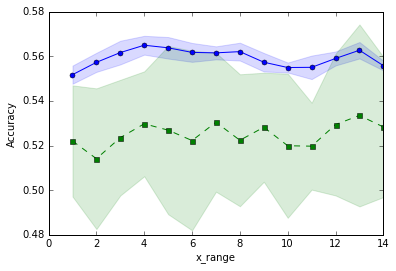

In [99]:
train_means,train_std,test_means,test_std,first2_mean=testRecentNum(1 ,15)

In [ ]:

proba = mlp.predict_proba(X_test)
precisionMatrix(proba,y_test)



In [ ]:
#future
mlp.fit(X,y)
inData = c.readPredict("future.csv")
print(inData)
X_in, y_in = c.getH6(5,target=inData)
res = mlp.predict(X_in)
proba= mlp.predict_proba(X_in)
print(mlp.score(X_in,y_in))
print (np.hstack([proba,y_in]))


In [ ]:
return
print(X.shape)

In [68]:
X,y = c.getH7(5, encode=False)


start format
 progress 1812finish


In [69]:
print(X.shape)
df = pd.DataFrame(np.hstack([X,y.reshape(y.shape[0],1)]))

df.columns = ['home','away','Referee','time','prevTimeDiff','hw','hd','hl','hscore','hconcede',
'hw2','hd2','hl2','hscore2','hconcede2','aw','ad','al','ascore','aconcede',
              'aw2','ad2','al2','ascore2','aconcede2','y']
print(df)

(1616, 25)
                home            away        Referee     time prevTimeDiff  \
0                QPR        Man City     M Atkinson  15283.0          5.0   
1         Man United      Sunderland        L Mason  15283.0          2.0   
2          Liverpool         Swansea         P Dowd  15283.0          6.0   
3        Aston Villa         Norwich       K Friend  15283.0          7.0   
4            Arsenal       West Brom       M Oliver  15283.0          3.0   
5          Blackburn         Chelsea         M Dean  15283.0          7.0   
6             Bolton           Stoke         H Webb  15284.0          8.0   
7             Fulham       Tottenham       P Walton  15284.0          2.0   
8             Wolves           Wigan      L Probert  15284.0          8.0   
9          West Brom          Bolton    N Swarbrick  15297.0         14.0   
10             Wigan       Blackburn     A Marriner  15297.0         13.0   
11           Swansea      Man United         M Dean  15297.0     

In [70]:

df.to_csv('dataSet/restTime.csv',index=False)